### Importing modules

In [14]:
import os
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import h3

#### Filter area (channel island)

In [15]:
#channel island area
park = pd.read_csv(f'''{os.path.abspath("../Data/final_csv")}/park.csv''')

In [16]:
park["omnisci_geo"] = park['omnisci_geo'].apply(loads)

In [17]:
park.set_geometry("omnisci_geo")

,omnisci_geo
0,"MULTIPOLYGON (((-120.12074 33.89521, -120.1114..."


In [18]:
park['omnisci_geo'][0].bounds

(-120.243988009283, 33.8949272706615, -119.968643160522, 34.0358751332554)

#### _Importing packages_

In [19]:
from osgeo import gdal
import rasterio
import json
from rasterio.windows import from_bounds
from rasterio.enums import Resampling

In [20]:
%run gdal2xyz.ipynb

In [21]:
%run helper_functions.ipynb

#### _creating filtered tiff file for redband file_

In [22]:
#Reading the raster and get the metadata about it like number of bands and CRS
rasterMetadata = None
redBand_rasterPath = os.path.abspath("../Data/images/T10SGC_20220307T184229_B04.jp2")
with rasterio.open(redBand_rasterPath) as src:
    rasterMetadata = get_metadata(src,redBand_rasterPath)

In [23]:
rasterMetadata

{'height': 10980,
 'width': 10980,
 'crs': 'EPSG:32610',
 'bounds': '{"bottom": 3690240.0, "top": 3800040.0, "left": 699960.0, "right": 809760.0}',
 'band_count': 1,
 'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'name': '/usr/src/manoj/TigerChallenge/final_notebooks/Data/images/T10SGC_20220307T184229_B04',
 'affine': '{"a": 10.0, "b": 0.0, "c": 699960.0, "d": 0.0, "e": -10.0, "f": 3800040.0}'}

In [24]:
#checking if the raster is in required CRS(EPSG:4326), if not then reproject the raster to required CRS and save the new path
final_path_reprojected= ""
if check_in_correct_crs(rasterMetadata):
    final_path_reprojected = redBand_rasterPath
else:
    final_path_reprojected = do_reprojection(redBand_rasterPath)
    rasterMetadata['crs'] = 'EPSG:4326'

In [25]:
final_path_reprojected

'/usr/src/manoj/TigerChallenge/final_notebooks/UC1/temp/T10SGC_20220307T184229_B04.jp2'

In [26]:
#read a window out of final reprojected file containing our park area
from rasterio.mask import mask
with rasterio.open(final_path_reprojected) as src:
    out_meta = src.meta
    out_image, out_transform = mask(src, shapes=park['omnisci_geo'][0], crop=True)
    
    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform
    
    out_meta.update({"driver": "GTiff","height": out_image.shape[1],"width": out_image.shape[2],"transform": out_transform})
    

output_path = os.path.abspath(f"../Data/masked_images/{os.path.basename(final_path_reprojected).split('.')[0]}.tiff")
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)
    
os.remove(final_path_reprojected)
    

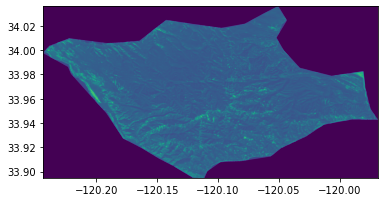

<AxesSubplot:>

In [27]:
from rasterio.plot import show
img = rasterio.open(output_path)
show(img)

#### reading filtered tiff file in redband dataframe

In [41]:
RedBandMetadata = None
redband_raster = output_path
with rasterio.open(redband_raster) as src:
    RedBandMetadata = get_metadata(src,redband_raster)

In [42]:
RedBandMetadata

{'height': 1425,
 'width': 2783,
 'crs': 'EPSG:4326',
 'bounds': '{"bottom": 33.89492723296544, "top": 34.03595769504544, "left": -120.24399324639676, "right": -119.96856322817315}',
 'band_count': 1,
 'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'name': '/usr/src/manoj/TigerChallenge/final_notebooks/Data/masked_images/T10SGC_20220307T184229_B04',
 'affine': '{"a": 9.896874531929724e-05, "b": 0.0, "c": -120.24399324639676, "d": 0.0, "e": -9.896874531929724e-05, "f": 34.03595769504544}'}

In [43]:
#to name bands in final csv 
column_names = []
columns = []    
for i in range(1,RedBandMetadata['band_count']+1):
    column_names.append(f"band{i}")
    columns.append(i)

In [44]:
#using gdal utility gdal2xyz we will convert raster to csv
srcfile= redband_raster
dstfile= os.path.join(os.path.abspath('../Data/tmp/'),f"{os.path.basename(redband_raster).split('.')[0]}.csv")
gdal2xyz(srcfile=srcfile,dstfile=dstfile,band_nums=columns)


In [45]:
dstfile= os.path.join(os.path.abspath('../Data/tmp/'),f"{os.path.basename(redband_raster).split('.')[0]}.csv")

In [46]:
tablename = os.path.basename(dstfile)

In [47]:
#by default gdal2xyz utility packs band values in one column with values space separated, 
#we need to separate these values to separate columns (comma separated)
if len(columns)>1:
    lines = []
    with open(dstfile, mode="r+") as infile:
        lines = infile.readlines()

    for i in range(0,len(lines)):
        lines[i] = lines[i].replace(" ",",")

    with open(f"{os.path.abspath('../Data/final_csv')}/{tablename}", mode="w+") as outfile:
        outfile.writelines(lines)
else:
    os.system(f'''cp "{os.path.abspath("../Data/tmp")}/{tablename}"  "{os.path.abspath("../Data/final_csv")}/{tablename}"''')

os.remove(dstfile)

In [48]:
column_names.insert(0,"longitude")
column_names.insert(1,"latitude")
column_names

['longitude', 'latitude', 'band1']

In [49]:
redband_df = pd.read_csv(f'''{os.path.abspath("../Data/final_csv")}/{tablename}''',names=['lng','lat','redband'])

In [50]:
redband_df.head(2)

,lng,lat,redband
0,-120.243944,34.035908,0
1,-120.243845,34.035908,0


In [51]:
len(redband_df)

3965775

In [52]:
redband_final = redband_df[['lng','lat','redband']]

In [53]:
redband_df = None

In [54]:
redband_final.head(2)

,lng,lat,redband
0,-120.243944,34.035908,0
1,-120.243845,34.035908,0


#### _creating filtered tiff file for NIR file_

In [55]:
#Reading the raster and get the metadata about it like number of bands and CRS
rasterMetadata = None
NIR_rasterPath = os.path.abspath("../Data/images/T10SGC_20220307T184229_B08.jp2")
with rasterio.open(NIR_rasterPath) as src:
    rasterMetadata = get_metadata(src,NIR_rasterPath)

In [56]:
#checking if the raster is in required CRS(EPSG:4326), if not then reproject the raster to required CRS and save the new path
final_path_reprojected= ""
if check_in_correct_crs(rasterMetadata):
    final_path_reprojected = NIR_rasterPath
else:
    final_path_reprojected = do_reprojection(NIR_rasterPath)
    rasterMetadata['crs'] = 'EPSG:4326'

In [57]:
final_path_reprojected

'/usr/src/manoj/TigerChallenge/final_notebooks/UC1/temp/T10SGC_20220307T184229_B08.jp2'

In [58]:
os.path.abspath(f"../Data/masked_images/{os.path.basename(final_path_reprojected).split('.')[0]}.tiff")

'/usr/src/manoj/TigerChallenge/final_notebooks/Data/masked_images/T10SGC_20220307T184229_B08.tiff'

In [59]:
#read a window out of final reprojected file containing our park area
from rasterio.mask import mask
with rasterio.open(final_path_reprojected) as src:
    out_meta = src.meta
    out_image, out_transform = mask(src, shapes=park['omnisci_geo'][0], crop=True)
    
    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform
    
    out_meta.update({"driver": "GTiff","height": out_image.shape[1],"width": out_image.shape[2],"transform": out_transform})
    

output_path = os.path.abspath(f"../Data/masked_images/{os.path.basename(final_path_reprojected).split('.')[0]}.tiff")
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)
    
os.remove(final_path_reprojected)
    

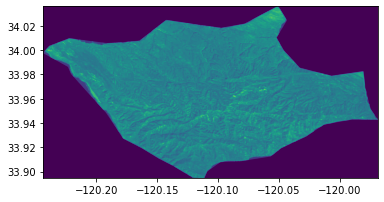

<AxesSubplot:>

In [60]:
from rasterio.plot import show
img = rasterio.open(output_path)
show(img)

#### reading filtered tiff file for NIR band

In [61]:
NIRMetadata = None
NIR_raster = output_path
with rasterio.open(NIR_raster) as src:
    NIRMetadata = get_metadata(src,NIR_raster)

In [62]:
NIRMetadata

{'height': 1425,
 'width': 2783,
 'crs': 'EPSG:4326',
 'bounds': '{"bottom": 33.89492723296544, "top": 34.03595769504544, "left": -120.24399324639676, "right": -119.96856322817315}',
 'band_count': 1,
 'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'name': '/usr/src/manoj/TigerChallenge/final_notebooks/Data/masked_images/T10SGC_20220307T184229_B08',
 'affine': '{"a": 9.896874531929724e-05, "b": 0.0, "c": -120.24399324639676, "d": 0.0, "e": -9.896874531929724e-05, "f": 34.03595769504544}'}

In [63]:
#to name bands in final csv 
column_names = []
columns = []    
for i in range(1,NIRMetadata['band_count']+1):
    column_names.append(f"band{i}")
    columns.append(i)

In [64]:
#using gdal utility gdal2xyz we will convert raster to csv
srcfile= NIR_raster
dstfile= os.path.join(os.path.abspath('../Data/tmp/'),f"{os.path.basename(NIR_raster).split('.')[0]}.csv")
gdal2xyz(srcfile=srcfile,dstfile=dstfile,band_nums=columns)


In [65]:
dstfile= os.path.join(os.path.abspath('../Data/tmp/'),f"{os.path.basename(NIR_raster).split('.')[0]}.csv")

In [66]:
tablename = os.path.basename(dstfile)

In [67]:
#by default gdal2xyz utility packs band values in one column with values space separated, 
#we need to separate these values to separate columns (comma separated)
if len(columns)>1:
    lines = []
    with open(dstfile, mode="r+") as infile:
        lines = infile.readlines()

    for i in range(0,len(lines)):
        lines[i] = lines[i].replace(" ",",")

    with open(f"{os.path.abspath('../Data/final_csv')}/{tablename}", mode="w+") as outfile:
        outfile.writelines(lines)
else:
    os.system(f'''cp "{os.path.abspath("../Data/tmp")}/{tablename}"  "{os.path.abspath("../Data/final_csv")}/{tablename}"''')

os.remove(dstfile)

In [68]:
column_names.insert(0,"longitude")
column_names.insert(1,"latitude")
column_names

['longitude', 'latitude', 'band1']

In [69]:
NIR_df = pd.read_csv(f'''{os.path.abspath("../Data/final_csv")}/{tablename}''',names=['lng','lat','nir'])

In [70]:
NIR_final = NIR_df[['lng','lat','nir']]

In [71]:
NIR_df = None

In [72]:
NIR_final.head(2)

,lng,lat,nir
0,-120.243944,34.035908,0
1,-120.243845,34.035908,0


#### ndvi calculation

In [73]:
ndvi_df = None

In [74]:
#function to calculate ndvi value
def cal_ndvi(row):
    if row['nir'] == 0 and row['redband']==0:
        return 0
    else:
        ndvi = (row['nir'] - row['redband'])/(row['nir'] + row['redband'])
        return ndvi

In [75]:
#function to calculate ndvi values for different resolutions of h3 (grouping on h3 index values of different resolutions)
def get_ndvi_at_res(redband_original,nir_original,res):
    
    redband_original['h3_index'] = ''
    nir_original['h3_index'] = ''
    
    print("calculating hex ids")
    
    redband_original['h3_index'] = redband_original.apply(lambda row: h3.geo_to_h3(row['lat'],row['lng'],res),axis=1)
    nir_original['h3_index'] = nir_original.apply(lambda row: h3.geo_to_h3(row['lat'],row['lng'],res),axis=1)
    
    print("merging redband and NIR dataframes")
    #merging both dataframe with lat long values equality condition
    ndvi_df = redband_original.merge(nir_original[['nir','lng','lat']], on = ['lng','lat'], how = 'outer')
    
    print("calculating ndvi values")
    ndvi_df['ndvi'] = ndvi_df.apply(lambda row: cal_ndvi(row),axis=1)
    
    print("grouping the ndvi dataframe on h3_index")
    ndvi_grpby = ndvi_df.groupby('h3_index').mean().reset_index()
    ndvi_grpby = ndvi_grpby[['lng','lat','h3_index','ndvi']]
    
    ndvi_df = None
    
    return ndvi_grpby

In [76]:
ndvi_res_10 = get_ndvi_at_res(redband_final,NIR_final,10)
len(ndvi_res_10)

calculating hex ids
merging redband and NIR dataframes
calculating ndvi values
grouping the ndvi dataframe on h3_index


24381

In [77]:
ndvi_res_10.to_csv(f"{os.path.abspath('../Data/final_csv/ndvi_res_10')}.csv")
ndvi_res_10 = None

In [78]:
ndvi_res_11 = get_ndvi_at_res(redband_final,NIR_final,11)

calculating hex ids
merging redband and NIR dataframes
calculating ndvi values
grouping the ndvi dataframe on h3_index


In [79]:
len(ndvi_res_11)

168956

In [80]:
ndvi_res_11.to_csv(f"{os.path.abspath('../Data/final_csv/ndvi_res_11')}.csv")
ndvi_res_11 = None

In [81]:
ndvi_res_12 = get_ndvi_at_res(redband_final,NIR_final,12)

calculating hex ids
merging redband and NIR dataframes
calculating ndvi values
grouping the ndvi dataframe on h3_index


In [82]:
len(ndvi_res_12)

1178451

In [83]:
ndvi_res_12.to_csv(f"{os.path.abspath('../Data/final_csv/ndvi_res_12')}.csv")
ndvi_res_12 = None